In [78]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np

In [79]:
class RoPE(nn.Module):
    def __init__(self,
                d = 128,
                max_len = 512,
                max_freq = 10000) -> None:
        super().__init__()
        self.d = d
        self.max_len = max_len
        self.max_freq = max_freq
        self.init_cos_sin_theta()
        
    def init_cos_sin_theta(self):
        thetas = 1000 ** (- torch.arange(0, self.d, 2).float() / self.d)
        pos_idx = torch.arange(self.max_len)
        thetas_ = torch.einsum('l, d -> l d', pos_idx, thetas)
        self.cos_theta = torch.cat([torch.cos(thetas_), torch.cos(thetas_)], dim=-1)
        self.sin_theta = torch.cat([torch.sin(thetas_), torch.sin(thetas_)], dim=-1)
    
    def forward(self, x):
        # use x_i and x_i+d/2 as a pair
        assert len(x.shape) == 4
        x2 = torch.cat([- x[:, :, :, d // 2: ], x[:, :, :, :self.d // 2]], dim=-1)
        seq_len = x.shape[-2]
        out = x * self.cos_theta[:seq_len:, :] + x2 * self.sin_theta[:seq_len, :]
        return out

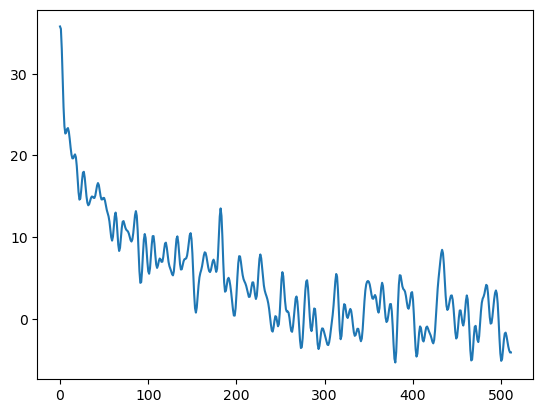

In [81]:
# use rand instead of randn to make magtitude always > 0
x = torch.rand(1, 1, 1, 128)
# use the same y, only var the positional encoding
y = torch.rand(1, 1, 1, 128).repeat(1, 1, 512, 1)
rope_pos_enc = RoPE()
pos_enc_x = rope_pos_enc(x)
pos_enc_y = rope_pos_enc(y)
pos_enc_x.shape, pos_enc_y.shape
mag = pos_enc_x.squeeze([0, 1]) @ pos_enc_y.squeeze([0, 1]).T
plt.plot(mag.squeeze())
plt.show()